In [3]:
from typing import List, Dict, Tuple
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt
import load_workload_data as ld
import load_benchmark_data as bn


sns.set(rc={'figure.figsize':(7.5,10)})

In [4]:
benchmark = "TPC-H"
single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
low_level_single: DataFrame = bn.get_low_level(single_threaded_folder)
high_level_mult

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Library Name,Compression Scheme,with_lto,Clients,Scale Factor,multithreaded,float,int,string,Library Name_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline
0,./hyriseBenchmarkTPCH_CompactVector_14_sf10_sh...,38.014279,0.360805,CompactVector,bitpacking_compactvector,False,14,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.922032,0.576155
1,./tpch_Dictionary_14_sf10_shuffled.json,41.228798,0.336834,Dictionary,dictionary_Hyrise,False,14,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,41.228798,1.372782e+09,1.000000,1.000000
2,./tpch_FrameOfReference_14_sf10_shuffled.json,38.446318,0.356780,FrameOfReference,for_Hyrise,False,14,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.932511,0.722096
3,./tpch_SIMDCAI_14_sf10_shuffled.json,39.593418,0.346463,SIMDCAI,for_SIMDCAI_simd,False,14,10,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.960334,0.470938
4,./tpch_TurboPFOR_14_sf10_shuffled.json,41.378711,0.331666,TurboPFOR,pfor_turboPFOR,False,14,10,True,676386560.0,6.514422e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,1.003636,0.474542
5,./tpch_TurboPFOR_bitpacking_14_sf10_shuffled.json,38.599272,0.355270,TurboPFOR_bitpacking,bitpacking_turboPFOR,False,14,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.936221,0.477655
6,./tpch_Unencoded_14_sf10_shuffled.json,36.699680,0.374132,Unencoded,unencoded_Hyrise,False,14,10,True,676386560.0,1.266756e+09,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.890147,0.922766
7,./hyriseBenchmarkTPCH_CompactVector_28_sf10_sh...,55.168860,0.497101,CompactVector,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.916339,0.576155
8,./tpch_Dictionary_28_sf10_shuffled.json,60.205721,0.460573,Dictionary,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
9,./tpch_FrameOfReference_28_sf10_shuffled.json,55.875643,0.490804,FrameOfReference,for_Hyrise,False,28,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.928079,0.722096


## Runtime


In [5]:
def load_all_benchmakrs_high_multi(benchmark: str, sf: int) -> DataFrame:
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf{sf}_singlethreaded/")
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf{sf}_multithreaded/")
    df = bn.get_high_level(multi_threaded_folder, sizes_folder)
    df["Benchmark"] = [benchmark for i in range(0, len(df))]
    return df[df[bn.CLIENTS] == 28]

all_benchmarks: DataFrame = load_all_benchmakrs_high_multi("TPC-H", 10)\
                                .append(load_all_benchmakrs_high_multi("TPC-DS", 10))\
                                .append(load_all_benchmakrs_high_multi("JOB", 10))

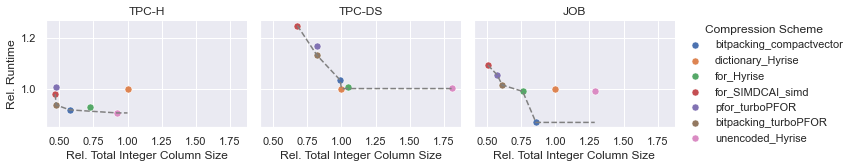

In [6]:
def pareto_frontier(Xs, Ys, maxX=False, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    return pareto_front

def connect_dominated_points(ax, data: DataFrame, x: str, y: str):
    x_values = list(data[x])
    y_values = list(data[y])
    par: List[Tuple[int, int]] = pareto_frontier(x_values, y_values)
    #print(par)
    par.append([max(x_values), par[-1][1]])
    ax.plot([p[0] for p in par], [p[1] for p in par], color="grey", linestyle="dashed")

g = sns.FacetGrid(all_benchmarks, col="Benchmark", hue=bn.PAPER_NAME, legend_out=True, height=2.5, aspect=1.3)
g.map(sns.scatterplot, bn.SIZE_TO_BASELINE, bn.RUNTIME_TO_BASELINE, s=50)
g.set_axis_labels("Rel. Total Integer Column Size", "Rel. Runtime")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
#
for ax in g.axes.flatten():
    benchmark = ax.title.get_text()
    data_for_benchmark = all_benchmarks[all_benchmarks["Benchmark"] == benchmark]
    connect_dominated_points(ax, data=data_for_benchmark, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE)

#plt.setp(g._legend.get_title(), fontsize=14.5)
#plt.setp(g._legend.get_texts(), fontsize=14.5)
    #plt.setp(ax.get_legend().get_texts(), fontsize=22)  # for legend text
    #plt.setp(ax.get_legend().get_title(), fontsize=22)  # for legend title

plt.savefig(f"visualizations/pareto_segment_encoding.svg", format="svg")


In [7]:
only_28_clients_mult = high_level_mult[high_level_mult[bn.CLIENTS] == 28]
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE]
high_level_single[columns_to_merge].merge(only_28_clients_mult[columns_to_merge], on=[bn.LIBRARY_NAME, bn.SIZE_TO_BASELINE])

,Library Name,Runtime Library / Runtime Baseline _x,size_to_baseline,Runtime Library / Runtime Baseline _y
0,CompactVector,0.911075,0.576155,0.916339
1,Dictionary,1.000000,1.000000,1.000000
2,FrameOfReference,0.914850,0.722096,0.928079
3,SIMDCAI,0.950550,0.470938,0.977628
4,TurboPFOR_bitpacking,0.905303,0.477655,0.935553
5,TurboPFOR,0.960166,0.474542,1.007754
6,Unencoded,0.866277,0.922766,0.904288


In [8]:
def load_segment_sizes(benchmark: str, libraries: List[str]) -> DataFrame:
    final_result: DataFrame = DataFrame()
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
    dictionary[bn.LIBRARY_NAME] = ["Dictionary" for i in range(0,len(dictionary))]
    dictionary[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in dictionary[bn.LIBRARY_NAME]]
    for library in libraries:
        integer_compressed: DataFrame = bn.load_sizes(sizes_folder / f"sizes_{library}.txt")
        integer_compressed[bn.LIBRARY_NAME] = [library for i in range(0,len(integer_compressed))]
        integer_compressed[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in integer_compressed[bn.LIBRARY_NAME]]
        columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES, bn.LIBRARY_NAME, bn.PAPER_NAME]
        merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],suffixes=("","_baseline"))
        merged[bn.SIZE_TO_BASELINE] = [x / y
                                     for x, y in zip(merged[bn.SIZE_IN_BYTES],
                                                     merged[f"{bn.SIZE_IN_BYTES}_baseline"])]
        int_columns = merged[merged[bn.DATA_TYPE] == "int"]
        final_result = final_result.append(int_columns)
    final_result["Benchmark"] = [benchmark for i in range(0,len(final_result))]
    return final_result

In [9]:
libraries: List[str] = list(high_level_mult[bn.LIBRARY_NAME].drop_duplicates())
libraries.remove("Dictionary")
sizes = load_segment_sizes("TPC-H", libraries).append(load_segment_sizes("TPC-DS", libraries)).append(load_segment_sizes("JOB", libraries))
sizes = sizes.sort_values(by=[bn.PAPER_NAME])
without_unencoded = sizes[sizes[bn.LIBRARY_NAME] == "CompactVector"]

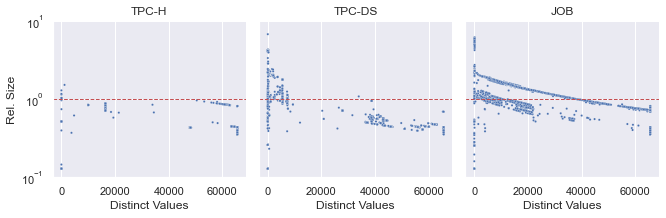

In [10]:
grid = sns.FacetGrid(without_unencoded, col="Benchmark", height=3, col_order=["TPC-H", "TPC-DS", "JOB"])
grid.map_dataframe(sns.scatterplot, x="distinct_value_count", y=bn.SIZE_TO_BASELINE, hue=bn.PAPER_NAME, s=5).set(yscale = 'log', ylim=(0.1, 10))
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=1, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Rel. Size")
grid.set_xlabels("Distinct Values")
plt.savefig("visualizations/benchmarks_size_closer.png", bbox_inches="tight", dpi=600)

In [11]:
def load_benchmark_high_level(benchmark: str, sizes_folder: Path) -> DataFrame:
    single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
    high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
    combined = high_level_mult.append(high_level_single)
    combined["Benchmark"] = [benchmark for i in range(0, len(combined)) ]
    return combined

all_results = load_benchmark_high_level("TPC-H", sizes_folder)\
                .append(load_benchmark_high_level("TPC-DS", sizes_folder))\
                .append(load_benchmark_high_level("JOB", sizes_folder))
without_dict  = all_results[all_results[bn.LIBRARY_NAME] != "Dictionary"]
without_dict = without_dict.sort_values(by=[bn.PAPER_NAME])

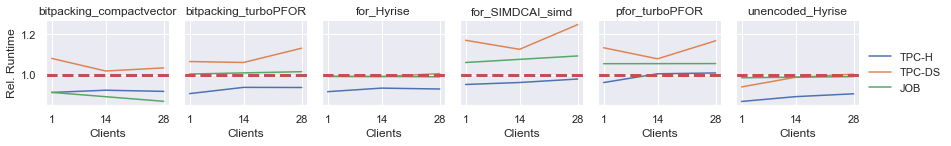

In [12]:
grid = sns.FacetGrid(without_dict, col=bn.PAPER_NAME, height=2)
grid.map_dataframe(sns.lineplot, x=bn.CLIENTS, y=bn.RUNTIME_TO_BASELINE, hue="Benchmark", hue_order=["TPC-H", "TPC-DS", "JOB"]).set(xticks=[1,14,28])
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=3, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Rel. Runtime")
grid.set_xlabels("Clients")
grid.add_legend()
plt.savefig("visualizations/benchmarks_runtime_closer.svg", bbox_inches="tight")

In [13]:
def load_benchmark_with_sf(benchmark: str, sf: int) -> DataFrame:
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf{sf}_multithreaded/")
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    df = bn.get_high_level(multi_threaded_folder, sizes_folder)
    return df[df[bn.CLIENTS] == 28]

all_combined: DataFrame = load_benchmark_with_sf("TPC-H", 1)\
                            .append(load_benchmark_with_sf("TPC-H", 10))\
                            .append(load_benchmark_with_sf("TPC-H",50))

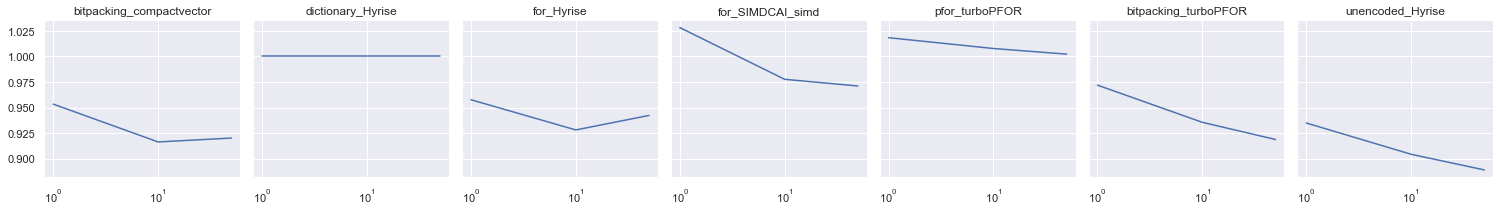

In [14]:
grid = sns.FacetGrid(all_combined, col=bn.PAPER_NAME)
grid.map_dataframe(sns.lineplot, x=bn.SCALE_FACTOR, y=bn.RUNTIME_TO_BASELINE).set(xscale="log")
grid.set_titles(col_template="{col_name}")

In [15]:
all_combined

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Library Name,Compression Scheme,with_lto,Clients,Scale Factor,multithreaded,float,int,string,Library Name_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline
7,./hyriseBenchmarkTPCH_CompactVector_28_sf1_shu...,4.407930,6.184807,CompactVector,bitpacking_compactvector,False,28,1,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.953317,0.576155
8,./hyriseBenchmarkTPCH_Dictionary_28_sf1_shuffl...,4.623782,5.908670,Dictionary,dictionary_Hyrise,False,28,1,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.000000,1.000000
9,./hyriseBenchmarkTPCH_FrameOfReference_28_sf1_...,4.427861,6.157377,FrameOfReference,for_Hyrise,False,28,1,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.957627,0.722096
10,./hyriseBenchmarkTPCH_SIMDCAI_28_sf1_shuffled....,4.754145,5.745949,SIMDCAI,for_SIMDCAI_simd,False,28,1,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.028194,0.470938
11,./hyriseBenchmarkTPCH_TurboPFOR_28_sf1_shuffle...,4.708573,5.799958,TurboPFOR,pfor_turboPFOR,False,28,1,True,676386560.0,6.514422e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.018338,0.474542
12,./hyriseBenchmarkTPCH_TurboPFOR_bitpacking_28_...,4.493912,6.069953,TurboPFOR_bitpacking,bitpacking_turboPFOR,False,28,1,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.971913,0.477655
13,./hyriseBenchmarkTPCH_Unencoded_28_sf1_shuffle...,4.322660,6.302859,Unencoded,unencoded_Hyrise,False,28,1,True,676386560.0,1.266756e+09,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.934875,0.922766
7,./hyriseBenchmarkTPCH_CompactVector_28_sf10_sh...,55.168860,0.497101,CompactVector,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.916339,0.576155
8,./tpch_Dictionary_28_sf10_shuffled.json,60.205721,0.460573,Dictionary,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
9,./tpch_FrameOfReference_28_sf10_shuffled.json,55.875643,0.490804,FrameOfReference,for_Hyrise,False,28,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.928079,0.722096


## Cache

In [16]:
benchmark = "TPC-H"
sf10_folder = Path(f"../data/nemea_{benchmark}_sf10_perf")
sf30_folder: Path = Path(f"../data/nemea_{benchmark}_sf30_perf")
sf1_folder: Path = Path(f"../data/nemea_{benchmark}_sf1_perf")
high_level_sf10: DataFrame = bn.get_high_level(sf10_folder, sf10_folder)
high_level_sf30: DataFrame = bn.get_high_level(sf30_folder, sf30_folder)
high_level_sf1: DataFrame = bn.get_high_level(sf1_folder, sf1_folder)

In [17]:
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE]
high_level_sf10[columns_to_merge].merge(high_level_sf1[columns_to_merge], on=[bn.LIBRARY_NAME])

,Library Name,Runtime Library / Runtime Baseline _x,size_to_baseline_x,Runtime Library / Runtime Baseline _y,size_to_baseline_y
0,CompactVector,0.915542,0.576155,0.948230,0.660729
1,Dictionary,1.000000,1.000000,1.000000,1.000000
2,FrameOfReference,0.927696,0.722096,0.958508,0.781401
3,SIMDCAI,0.979859,0.470938,1.023928,0.515864
4,TurboPFOR,1.005736,0.474542,1.016647,0.517243
5,TurboPFOR_bitpacking,0.947954,0.477655,0.973697,0.520400
6,Unencoded,0.906204,0.922766,0.934015,1.169736


In [18]:
CACHE_EVENT: str = "cache_event"
VALUE: str = "Value"
INT_IN_GB: str = "Total Integer Size (in GB)"

def load_cache(path: Path) -> DataFrame:
    df: DataFrame = DataFrame()
    with path.open() as file:
        for line in file:
            if "<not supported>" in line:
                continue
            if not "l2" in line and not "LLC" in line:
                continue
            if "store" in line or "hit" in line:
                continue
            df[line.split()[1]] = [int(line.split()[0])]
    return df

def rename_name(cache_event: str) -> str:
    rename: Dict[str, str] = {
        "l2_rqsts.all_demand_data_rd:u" : "L2 Read",
        "l2_rqsts.demand_data_rd_miss:u" : "L2 Miss",
        "LLC-loads:u": "L3 Read",
        "LLC-load-misses:u": "L3 Miss"
    }
    return rename[cache_event]

def complete_with_cache_results(data: DataFrame, base_folder) -> DataFrame:
    all_results: DataFrame = DataFrame()
    scale_factor: int = data[bn.SCALE_FACTOR][0]
    for library in data[bn.LIBRARY_NAME]:
        cache_results: DataFrame = load_cache(base_folder / f"{library}_cache_sf{scale_factor}_multi.txt") \
                                   - load_cache(base_folder / f"{library}_baseline_sf{scale_factor}_multi.txt")
        cache_results[bn.LIBRARY_NAME] = library
        for column in list(cache_results):
            if column == bn.LIBRARY_NAME:
                continue
            base_throughput: int = list(data[data[bn.LIBRARY_NAME] == "Dictionary"]["avg_throughput"])[0]
            lib_throughput: int = list(data[data[bn.LIBRARY_NAME] == library]["avg_throughput"])[0]
            new_df: DataFrame = DataFrame({bn.LIBRARY_NAME: [library],
                                           CACHE_EVENT: column,
                                           VALUE: cache_results[column][0] * base_throughput / lib_throughput})
            all_results = all_results.append(new_df)
    merged = all_results.merge(data, on=[bn.LIBRARY_NAME])
    return merged

data = complete_with_cache_results(high_level_sf10, sf10_folder)
data[CACHE_EVENT] = [rename_name(event) for event in data[CACHE_EVENT]]
data[INT_IN_GB] = [number / 1e9 for number in data["int"]]
data = data.sort_values([bn.PAPER_NAME])
with_broken_name = data.copy()
with_broken_name[bn.PAPER_NAME] = [paper_name.replace("_", "\n_") for paper_name in with_broken_name[bn.PAPER_NAME]]

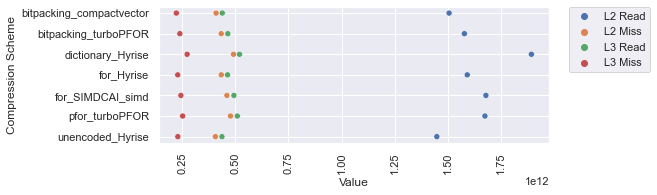

In [29]:
plt.figure(figsize=(7,2.5))
lineplot = sns.scatterplot(data=data, x=VALUE, y=bn.PAPER_NAME, hue=CACHE_EVENT)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
lineplot.get_legend().set_title(None)
plt.savefig("visualizations/Segment_Cache.svg", bbox_inches="tight")

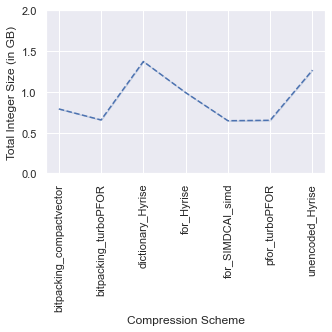

In [20]:
plt.figure(figsize=(5,3))
lineplot = sns.lineplot(data=data, x=INT_IN_GB, y=bn., linestyle="--").set_ylim(0,2)
plt.xticks(rotation=90)
plt.savefig("visualizations/Segment_Cache_Size.svg", bbox_inches="tight")

In [21]:
data

,Library Name,cache_event,Value,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,Clients,Scale Factor,multithreaded,float,int,string,Library Name_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline,Total Integer Size (in GB)
0,CompactVector,L2 Read,1.506555e+12,./tpch_CompactVector_28_sf10_shuffled.json,54.500662,0.498603,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.915542,0.576155,0.790935
1,CompactVector,L2 Miss,4.087844e+11,./tpch_CompactVector_28_sf10_shuffled.json,54.500662,0.498603,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.915542,0.576155,0.790935
2,CompactVector,L3 Read,4.379846e+11,./tpch_CompactVector_28_sf10_shuffled.json,54.500662,0.498603,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.915542,0.576155,0.790935
3,CompactVector,L3 Miss,2.216665e+11,./tpch_CompactVector_28_sf10_shuffled.json,54.500662,0.498603,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.915542,0.576155,0.790935
23,TurboPFOR_bitpacking,L3 Miss,2.382047e+11,./tpch_TurboPFOR_bitpacking_28_sf10_shuffled.json,56.430087,0.480601,bitpacking_turboPFOR,False,28,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.947954,0.477655,0.655717
22,TurboPFOR_bitpacking,L3 Read,4.642384e+11,./tpch_TurboPFOR_bitpacking_28_sf10_shuffled.json,56.430087,0.480601,bitpacking_turboPFOR,False,28,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.947954,0.477655,0.655717
21,TurboPFOR_bitpacking,L2 Miss,4.330681e+11,./tpch_TurboPFOR_bitpacking_28_sf10_shuffled.json,56.430087,0.480601,bitpacking_turboPFOR,False,28,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.947954,0.477655,0.655717
20,TurboPFOR_bitpacking,L2 Read,1.578581e+12,./tpch_TurboPFOR_bitpacking_28_sf10_shuffled.json,56.430087,0.480601,bitpacking_turboPFOR,False,28,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,59.528286,1.372782e+09,0.947954,0.477655,0.655717
4,Dictionary,L2 Read,1.894380e+12,./tpch_Dictionary_28_sf10_shuffled.json,59.528286,0.464820,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,59.528286,1.372782e+09,1.000000,1.000000,1.372782
5,Dictionary,L2 Miss,4.909374e+11,./tpch_Dictionary_28_sf10_shuffled.json,59.528286,0.464820,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,59.528286,1.372782e+09,1.000000,1.000000,1.372782
